# Preliminary - Brokers' notes classification
18/04/2018 @MAV Python 3 (compatible with PyPDF2)
<br><br>Introduction: This notebook is a first attempt at classifying brokers' notes betwwen categories (single stock, sector, macroeconomy ...) and sub-categories (Capital, human resources, outstanding event ...).
<br>--

In [37]:
import os
import time
import re

import pandas as pd
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.svm import SVC

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

import nltk
import spacy

import PyPDF2

Construct PDF database as a Panda DataFrame from Numpy array

In [38]:
#This function takes a folder path as an argument, scans for PDFs and returns a dataframe with metadata
def myDataFrameCreator(myFolderPath,myType):
    columns=["name_file","size_file","name_author","name_category","name_company","date_creation","name_topic","title_document","count_pages","type_isSingleStock"]
    myDFWidth=len(columns)
    myDataFrame=pd.DataFrame(index=[],columns=columns)
    for myFile in os.listdir(myFolderPath):
        fileExtension = os.path.splitext(myFile)[1]
        if fileExtension=='.pdf':
            #Initializing Numpy array and storing basic file data
            myInfo=np.array([os.path.basename(myFile)[:-4],os.stat(myFolderPath+'/'+myFile).st_size])
            myPDFReader=PyPDF2.PdfFileReader(open(myFolderPath+'/'+myFile,'rb'),strict=False)
            #Adding metadata if available
            for key in ['/Author','/Category','/Company','/CreationDate', '/Subject','/Title']:
                myInfo=np.append(myInfo,[myPDFReader.getDocumentInfo().get(key)])
            #Adding inside PDF data
            pagesCount=myPDFReader.numPages;
            myInfo=np.append(myInfo,[pagesCount,myType])
        #Adding current file info to global DataFrame
        myDataFrame.loc[len(myDataFrame)]=myInfo
    return myDataFrame

In [39]:
#True are "Single stock" related notes
myFolderPath_False="/media/sf_Shared/Documents_NotesBroker_20180416/IsNot_SingleStock/"
myFolderPath_True="/media/sf_Shared/Documents_NotesBroker_20180416/Is_SingleStock/"

In [40]:
startTime=time.time()
myDataFrame_False=myDataFrameCreator(myFolderPath_False,False)
print("Runtime is "+ str(time.time()-startTime) + "s")

Runtime is 13.443019390106201s


In [41]:
startTime=time.time()
myDataFrame_True=myDataFrameCreator(myFolderPath_True,True)
print("Runtime is "+ str(time.time()-startTime) + "s")

Runtime is 9.190485715866089s


In [42]:
myDataFrame=pd.concat([myDataFrame_False,myDataFrame_True])
myDataFrame

,name_file,size_file,name_author,name_category,name_company,date_creation,name_topic,title_document,count_pages,type_isSingleStock
0,MorganStanley_VideoMachineryandCapitalGoodsOnt...,392106,None,None,None,D:20180420035703-04'00',None,Video | Machinery and Capital Goods: On the Ro...,8,0
1,MorganStanley_VideoOilGasHowDigitalisationMayD...,266524,None,None,None,D:20180417125245-04'00',None,Video | Oil & Gas: How Digitalisation May Driv...,9,0
2,MorganStanley_VideoThailandSpectrumAuction2018...,253222,None,None,None,D:20180419022651-04'00',None,None,8,0
3,MorganStanley_WeekAheadinLatinAmericaMexicoCha...,578769,None,None,None,D:20180419205608-04'00',None,Week Ahead in Latin America: Mexico: Challengi...,22,0
4,"SanfordCBernsteinCo,LLC_BTWAsiaTheHighTeakRevo...",815342,Michael W. Parker,None,None,D:20180420071745,,BTW Asia: The High Teak Revolution... India's ...,29,0
5,"SanfordCBernsteinCo,LLC_USPortfolioStrategyApr...",413472,Noah Weisberger,None,None,D:20180418215455,,US Portfolio Strategy: April Market Essentials...,11,0
6,MorganStanley_LatinAmericaMetalsMining1Q18Prev...,530905,None,None,None,D:20180418210851-04'00',None,None,19,0
7,MorganStanley_MachineryUSDealerSurveyAsStronga...,1038211,None,None,None,D:20180417225854-04'00',None,Machinery: US Dealer Survey: As Strong as Ever,15,0
8,MorganStanley_MajorPharmaceuticalsBariFDApanel...,270499,None,None,None,D:20180419093159-04'00',None,Major Pharmaceuticals: Bari FDA panel doc rais...,11,0
9,MorganStanley_MarineTransportationLookforNear-...,1270482,None,None,None,D:20180420030327-04'00',None,Marine Transportation: Look for Near-term Rebo...,26,0


What categories are we trying to cluster our files into?

In [43]:
myCategories=["Single Stock","Strategic sector analysis","Macro analysis"]
mySubCategories=["Capital Changes (SEO, capital reduction etc.)","Externalities","M&A","Management Changes","Partnership","Results","Solvency","Strategic Changes"]

Parse file titles and first NLP analysis

In [44]:
myDataFrame["tokenized_name_file"]=myDataFrame["name_file"]
myNames=myDataFrame["tokenized_name_file"].as_matrix()

In [45]:
#This function takes an array as an argument and returns it with standardized strings
def myNamesStandardizer(myArray):
    i=0;
    for name in myArray:
        name=re.sub(r"(\w)([A-Z])",r"\1 \2", name[:-13])
        name=re.sub(r"[_,()]"," ",name)
        name=name.lower()
        myArray[i]=name
        i+=1
    return myArray

In [46]:
myNames=myNamesStandardizer(myNames)

In [47]:
def myNamesTokenizer(myArray):
    myTokenizer=nltk.tokenize.RegexpTokenizer(r'\w+')
    i=0
    for name in myArray:
        myArray[i]=list(set(myTokenizer.tokenize(name)))
        i+=1
    return myArray

In [48]:
#myNames=myNamesTokenizer(myNames)
#total count of words
allWords=[word for name in myDataFrame['tokenized_name_file'] for word in name]
print(len(allWords))
myVocabulary=sorted(list(set(allWords)))
print(len(myVocabulary))

53042
43


In [49]:
myDataFrame

,name_file,size_file,name_author,name_category,name_company,date_creation,name_topic,title_document,count_pages,type_isSingleStock,tokenized_name_file
0,MorganStanley_VideoMachineryandCapitalGoodsOnt...,392106,None,None,None,D:20180420035703-04'00',None,Video | Machinery and Capital Goods: On the Ro...,8,0,morgan stanley video machineryand capital goo...
1,MorganStanley_VideoOilGasHowDigitalisationMayD...,266524,None,None,None,D:20180417125245-04'00',None,Video | Oil & Gas: How Digitalisation May Driv...,9,0,morgan stanley video oil gas how digitalisati...
2,MorganStanley_VideoThailandSpectrumAuction2018...,253222,None,None,None,D:20180419022651-04'00',None,None,8,0,morgan stanley video thailand spectrum auctio...
3,MorganStanley_WeekAheadinLatinAmericaMexicoCha...,578769,None,None,None,D:20180419205608-04'00',None,Week Ahead in Latin America: Mexico: Challengi...,22,0,morgan stanley week aheadin latin america mex...
4,"SanfordCBernsteinCo,LLC_BTWAsiaTheHighTeakRevo...",815342,Michael W. Parker,None,None,D:20180420071745,,BTW Asia: The High Teak Revolution... India's ...,29,0,sanford cbernstein co l lc bt wasia the high ...
5,"SanfordCBernsteinCo,LLC_USPortfolioStrategyApr...",413472,Noah Weisberger,None,None,D:20180418215455,,US Portfolio Strategy: April Market Essentials...,11,0,sanford cbernstein co l lc us portfolio strat...
6,MorganStanley_LatinAmericaMetalsMining1Q18Prev...,530905,None,None,None,D:20180418210851-04'00',None,None,19,0,morgan stanley latin america metals mining1 q...
7,MorganStanley_MachineryUSDealerSurveyAsStronga...,1038211,None,None,None,D:20180417225854-04'00',None,Machinery: US Dealer Survey: As Strong as Ever,15,0,morgan stanley machinery us dealer survey as ...
8,MorganStanley_MajorPharmaceuticalsBariFDApanel...,270499,None,None,None,D:20180419093159-04'00',None,Major Pharmaceuticals: Bari FDA panel doc rais...,11,0,morgan stanley major pharmaceuticals bari fd ...
9,MorganStanley_MarineTransportationLookforNear-...,1270482,None,None,None,D:20180420030327-04'00',None,Marine Transportation: Look for Near-term Rebo...,26,0,morgan stanley marine transportation lookfor ...


##  First strategy: raw Bag of Words and PCA

In [16]:
def myCount(data):
    myCountVectorizer=sklearn.feature_extraction.text.CountVectorizer()
    countedData=myCountVectorizer.fit_transform(data)
    return countedData,myCountVectorizer

In [17]:
myListofNames=myDataFrame['tokenized_name_file'].tolist()
myListofLabels=myDataFrame['type_isSingleStock'].tolist()
X_train,X_test,Y_train,Y_test=sklearn.model_selection.train_test_split(myListofNames,myListofLabels, test_size=0.2,random_state=40)
X_train_counts, count_vectorizer=myCount(X_train)
X_test_counts=count_vectorizer.transform(X_test)

In [18]:
X_train_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [19]:
print(count_vectorizer.vocabulary_.get('high'))

884


In [20]:
def plot_LSA(test_data, test_labels, plot=True,n_components=2):
        lsa = TruncatedSVD(n_components=n_components)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','green','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            SingleStock_patch = mpatches.Patch(color='orange', label='Single Stock')
            NotSingleStock_patch = mpatches.Patch(color='blue', label='Not Single Stock')
            plt.legend(handles=[SingleStock_patch,NotSingleStock_patch])

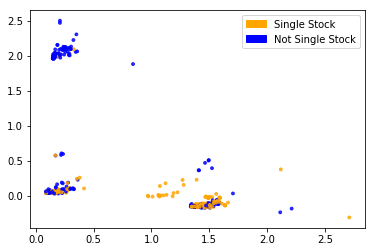

In [21]:
plot_LSA(X_train_counts, Y_train)
plt.show()

Clustering opportunities are poor: need for a broader DB w/ better preprocessing (TF IDF and Word2Vec)

## Second strategy: TF IDF and Word2Vec

In [21]:
#This function takes as argument the test and prediucted output to measure performance
def get_metrics(y_test,y_predicted):
    precision=sklearn.metrics.precision_score(y_test,y_predicted,pos_label=None,average='weighted')
    recall=sklearn.metrics.recall_score(y_test,y_predicted,pos_label=None,average='weighted')
    f1=sklearn.metrics.f1_score(y_test,y_predicted,pos_label=None,average='weighted')
    accuracy=sklearn.metrics.accuracy_score(y_test,y_predicted)
    return accuracy,precision,recall,f1

In [22]:
def tfidf(data):
    tfidf_vectorizer=sklearn.feature_extraction.text.TfidfVectorizer()
    train=tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

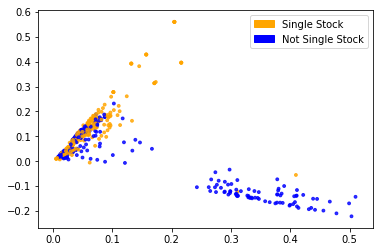

In [23]:
X_train_tfidf, tfidf_vectorizer=tfidf(X_train)
X_test_tfidf=tfidf_vectorizer.transform(X_test)
fig=plt.figure()
plot_LSA(X_train_tfidf,Y_train)
plt.show()

The results are much better, we can try to fit a model overe the data

In [24]:
clf_tfidf=sklearn.linear_model.LogisticRegression(C=30,class_weight='balanced',solver='newton-cg',multi_class='multinomial',n_jobs=-1,random_state=40)
clf_tfidf.fit(X_train_tfidf,Y_train)
Y_predicted_tfidf=clf_tfidf.predict(X_test_tfidf)
get_metrics(Y_test,Y_predicted_tfidf)

(0.9583333333333334, 0.959515202076381, 0.9583333333333334, 0.9583246521749196)

Accuracy, Precision, Recall and F1

In [25]:
myCM=sklearn.metrics.confusion_matrix(Y_test,Y_predicted_tfidf)
myCM

array([[57,  4],
       [ 1, 58]])

TP=57, FP=1, FN=4, TN=58 ;
There are slightly more FN than FP, meaning the model is slightly more likely to be wrong when categorizing as Not SIngleStock while they are actually.

In [26]:
i=0
for name in X_test:
    if Y_test[i]!=Y_predicted_tfidf[i]:
        print('Predicted wrong: '+str(Y_predicted_tfidf[i])+" - " +str(name))
    i+=1

Predicted wrong: 1 - morgan stanley  large cap banks mar18 master trust slower dqsat df spositivefor our overweight thesis
Predicted wrong: 1 - morgan stanley  healthcare services distribution taking fy19 estimates below cons
Predicted wrong: 1 - j pmorgan  packaging1 q18 earnings preview widening discountto market not justified given solid defensive growth outlook
Predicted wrong: 1 - j pmorgan  life science diagnostics interphex2018 continued bioprocessing strength accelerating single-use adoption are positivefor dh rt mo ct lt rg en
Predicted wrong: 0 - morgan stanley  pp lcorp digging intothe valueofthe uk business


Based off these good performances, let's try to find the most discriminating words

In [28]:
def get_ranked_words(vectorizer,model,n=10):
    index_to_word={v:k for k,v in vectorizer.vocabulary_.items()}
    
    classes={}
    for class_index in range(model.coef_.shape[0]):
        word_importances=[(j,index_to_word[i]) for i,j in enumerate(model.coef_[class_index])]
        sorted_coeff=sorted(word_importances, reverse=True)
        tops=sorted(sorted_coeff[:n])
        bottoms=sorted_coeff[-n:]
        classes[class_index]={'tops':tops,'bottoms':bottoms}
        return classes

In [29]:
importance=get_ranked_words(tfidf_vectorizer,clf_tfidf)
importance

{0: {'bottoms': [(-1.928303873705598, 'japan'),
   (-2.031506986601112, 'equity'),
   (-2.0372453944880866, 'april'),
   (-2.077880620668046, 'stanley'),
   (-2.2898121666349223, 'morgan'),
   (-2.3405164286603557, 'jp'),
   (-2.8351753940554336, 'strategy'),
   (-2.842464935895438, 'weekly'),
   (-2.8604885860674623, 'videoe'),
   (-3.63862295531057, 'china')],
  'tops': [(1.8216719732321458, 'inc1'),
   (1.9520052601339688, 'pass'),
   (1.9701813690663224, 'johnson'),
   (2.0645583147749282, 'first'),
   (2.5686600996556437, 'cbernstein'),
   (2.5686600996556437, 'lc'),
   (2.5686600996556437, 'sanford'),
   (2.7780386618074666, 'corp'),
   (3.658795706843595, 'co'),
   (4.6697014306622915, 'inc')]}}

The model shows clear learning pattern with the different company suffixes but also bernstein and sanford which seem odd. Let's try to use Word2vec out of curiosity.

In [30]:
nlp=spacy.load('en')
#This function takes as an argument the list of names/tokens and returns the average word embeddings
def get_word2vec_embeddings(sentence):
    vectorized=[nlp(word).vector for word in sentence.split()]
    embeddings=np.divide(sum(vectorized),len(vectorized))
    return embeddings

In [31]:
tokens = []
for name in myListofNames:
    tokens.append(get_word2vec_embeddings(name))

In [32]:
tsne_model=TSNE(perplexity=40,n_components=2,init='pca',n_iter=2500,random_state=23)
new_values = tsne_model.fit_transform(tokens)

x=[]
y=[]
for value in new_values:
    x.append(value[0])
    y.append(value[1])

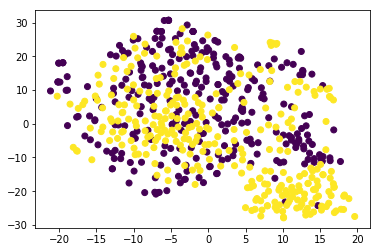

In [33]:
plt.figure()
plt.scatter(x,y,c=myListofLabels)

Mixed feeling about the use of Word2Vec: may require deeper study into potential applications for supervised learning

## Third strategy: using co-occurences over the tickers

In order to use co-occurences techniques, we will need to definetely extract part of the PDF to text. We will first focus on the first page for that.

In [50]:
myTextPath = '/media/sf_Shared/Documents_NotesBroker_20180416ExtractedText_Last.csv'
myTickerPath = '/media/sf_Shared/BDD_Ticker_20180428/Company Screening Report 2.xls'

In [51]:
myTextDF = pd.read_csv(myTextPath)
myTickerDF = pd.ExcelFile(myTickerPath).parse('Screening')

In [52]:
myTextDF['size_file']=myDataFrame['size_file'].tolist()
myTextDF['count_pages']=myDataFrame['count_pages'].tolist()

In [53]:
myTextDF

,Unnamed: 0,filename,category,firstpagetext,wordscount,size_file,count_pages
0,0,MorganStanley_VideoMachineryandCapitalGoodsOnt...,IsNot_SingleStock,"April 20, 2018 07:57 AM GMT\n\nVideo | Machine...",195,392106,8
1,1,MorganStanley_VideoOilGasHowDigitalisationMayD...,IsNot_SingleStock,"April 18, 2018 04:00 AM GMT\n\nVideo | Oil & G...",210,266524,9
2,2,MorganStanley_VideoThailandSpectrumAuction2018...,IsNot_SingleStock,MORGAN STANLEY ASIA (SINGAPORE) PTE.+\nMark Go...,248,253222,8
3,3,MorganStanley_WeekAheadinLatinAmericaMexicoCha...,IsNot_SingleStock,"April 20, 2018 04:01 AM GMT\n\nWeek Ahead in L...",585,578769,22
4,4,"SanfordCBernsteinCo,LLC_BTWAsiaTheHighTeakRevo...",IsNot_SingleStock,BLAST\n\n20 April 2018\n\n20 April 2018\n\nBTW...,561,815342,29
5,5,"SanfordCBernsteinCo,LLC_USPortfolioStrategyApr...",IsNot_SingleStock,19 April 2018\n\nU.S. Portfolio Strategy\nUS P...,173,413472,11
6,6,MorganStanley_LatinAmericaMetalsMining1Q18Prev...,IsNot_SingleStock,"April 19, 2018 01:09 AM GMT\n\nLatin America M...",544,530905,19
7,7,MorganStanley_MachineryUSDealerSurveyAsStronga...,IsNot_SingleStock,"April 18, 2018 04:02 AM GMT\n\nMachinery\nMach...",738,1038211,15
8,8,MorganStanley_MajorPharmaceuticalsBariFDApanel...,IsNot_SingleStock,"April 19, 2018 01:32 PM GMT\n\nMajor Pharmaceu...",602,270499,11
9,9,MorganStanley_MarineTransportationLookforNear-...,IsNot_SingleStock,"April 20, 2018 07:03 AM GMT\n\nMarine Transpor...",682,1270482,26


In [54]:
x = myTextDF['size_file'].astype(float)
x = (x - np.average(x))*1E-6
x = x.tolist()
y = myTextDF['count_pages'].tolist()
z = myTextDF['wordscount'].tolist()
colors = myDataFrame['type_isSingleStock'].tolist()
myFeatures=[[x[i],y[i],z[i]] for i in range(len(x))]

In [55]:
startTime=time.time()
mySVC=SVC(kernel='rbf').fit(myFeatures,colors)
print("Runtime is "+ str(time.time()-startTime) + "s")

Runtime is 0.08041191101074219s


In [56]:
w=mySVC.coef_
w1=w[:,0]
w2=w[:,1]
w3=w[:,2]
b = mySVC.intercept_
sv = mySVC.support_vectors_

AttributeError: coef_ is only available when using a linear kernel

In [57]:
xx, yy = np.meshgrid(range(-2,7,2),range(0,50,5))
zz = (-w1 * xx - w2 * yy - b) * 1./w3

NameError: name 'w1' is not defined

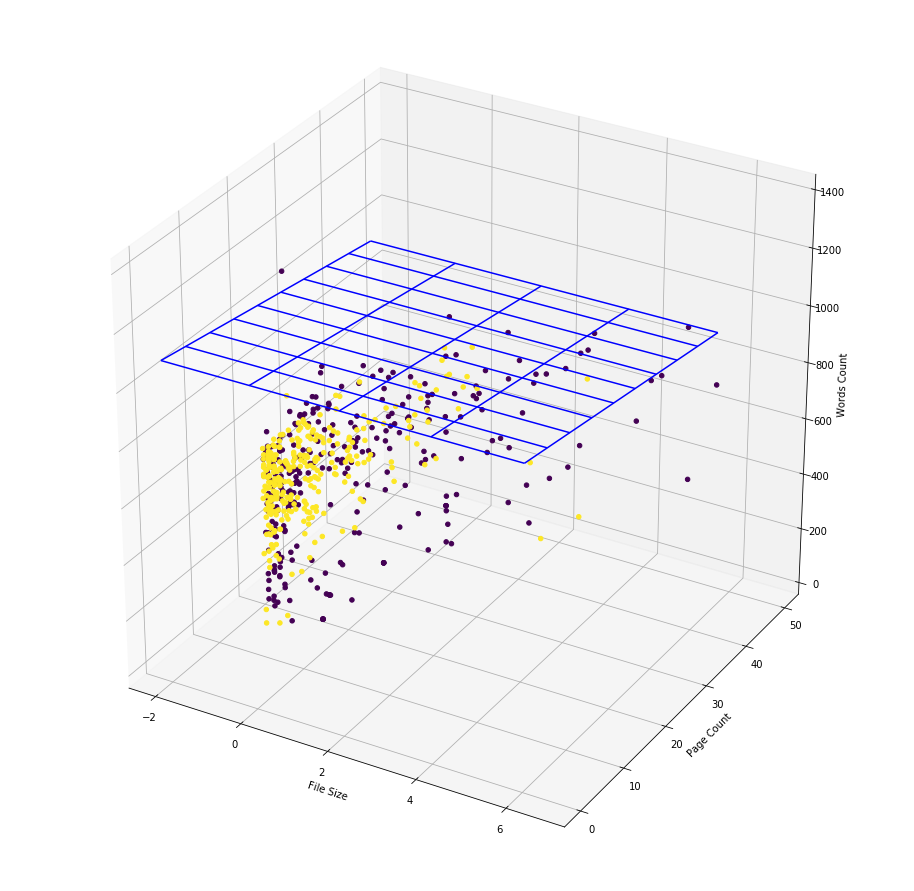

In [53]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(xx,yy,zz, rstride=1, cstride=1, color='blue')
ax.scatter(x,y,z,c=colors,depthshade=False)
ax.set_xlabel('File Size')
ax.set_ylabel('Page Count')
ax.set_zlabel('Words Count')
plt.show()

We also use a list of tickers whose company are of interest to us

In [27]:
myTickers = myTickerDF['Company Name']
myTickers[14]

'Wells Fargo & Company '

In [28]:
exclusionList=['The ','the ',' Corporation',' corporation',' Corp',' corp',' Corp.',' corp.',' Incorporated',' incorporated',
               ' Inc.',' inc.',' Limited',' limited',' Ltd.',' ltd.','L.P.',' Laboratories',' laboratories',' Funds',' funds',
               ' Fund',' fund',' Holdings','holdings',' Holding',' holding',' Company',' company',' & Company',
               ' & company',' Group',' group',' & Co.',' & co.',' Co.',' co.',' .com',',','-']
myExclusions='|'.join(exclusionList)
newTickersList=[re.sub(myExclusions,"",myTickers[i]) for i in range(len(myTickers))]
for i in range(len(newTickersList)):
        while newTickersList[i][-1:]==" ":
            newTickersList[i]=newTickersList[i][:-1]
        while newTickersList[i][:1]==" ":
            newTickersList[i]=newTickersList[i][1:] 

In [29]:
newTickersList[14]

'Wells Fargo'

Building the cooccurence matrix based on company names solely

In [30]:
startTime=time.time()
myCoocList=[]
k=0
for document in myTextDF['firstpagetext']:
    s=(len(myTextDF['firstpagetext'][k].split(".")),len(newTickersList))
    myTextMatrix=np.zeros(s)
    i=0
    for sentence in myTextDF['firstpagetext'][k].split("."):
        j=0
        for Ticker in newTickersList:
            if Ticker in sentence:
                myTextMatrix[i][j]+=1
            j+=1
        i+=1
    k+=1
    myTextMatrix.astype(int)
    myCoocList.append(myTextMatrix.T.dot(myTextMatrix))
print("Runtime is "+ str(time.time()-startTime) + "s")

Runtime is 556.1183979511261s


The resulting matrices are extremely sparse: only 0.7% filled. Let's try to find better data representation

In [32]:
Coocstats=[]
for ligne in myCoocList:
    countNotEmpty = 0
    count=0
    for colonne in ligne:
        countNotEmpty+=colonne.sum()
        count+=1
    Coocstats.append(countNotEmpty/count*100)

In [60]:
mySVCCooc=SVC(kernel='linear').fit(np.array(Coocstats).reshape(-1, 1),myListofLabels)

In [62]:
w=mySVCCooc.coef_

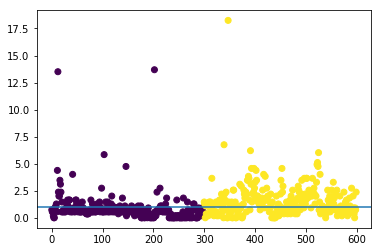

In [65]:
plt.figure()
plt.scatter(range(len(Coocstats)),Coocstats,c=myListofLabels)
plt.axhline(y=w.tolist()[0][0])